In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
from statsmodels.tsa.stattools import adfuller
import pandas.util.testing as tm

In [3]:
df=pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df_new=df.drop(columns=['RegionID', 'SizeRank', 'Metro', 'CountyName'])
df_new.head()

,RegionName,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName',  'City', 'State'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted
df_dates = melt_data(df_new)
df_dates.head()

,RegionName,City,State,Date,value
0,60657,Chicago,IL,1996-04-01,334200.0
1,75070,McKinney,TX,1996-04-01,235700.0
2,77494,Katy,TX,1996-04-01,210400.0
3,60614,Chicago,IL,1996-04-01,498100.0
4,79936,El Paso,TX,1996-04-01,77300.0


In [6]:
df_dates.set_index('Date', inplace = True)

recent = df_dates.loc['2013-01-01':'2018-04-01']
tx = recent[recent['State'] == 'TX']
austin_df = tx[tx['City'] == 'Austin']
austin_df.head()

,RegionName,City,State,value
Date,,,,
2013-01-01,78704,Austin,TX,383200.0
2013-01-01,78745,Austin,TX,177500.0
2013-01-01,78758,Austin,TX,142400.0
2013-01-01,78741,Austin,TX,141100.0
2013-01-01,78753,Austin,TX,133600.0


In [7]:
zips_grouped = austin_df.groupby(['RegionName'], as_index = True).resample('M').sum()
zips_grouped.drop(columns = 'RegionName', inplace=True)
zips_grouped.head()

value
RegionName Date                
78617      2013-01-31  121000.0
           2013-02-28  120700.0
           2013-03-31  120600.0
           2013-04-30  120800.0
           2013-05-31  121200.0

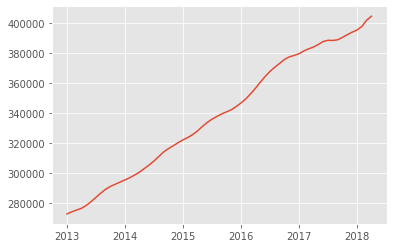

In [8]:
temp_monthly = austin_df.drop(columns=['RegionName', 'City', 'State']).resample('MS')
month_mean = temp_monthly.mean()
plt.plot(month_mean);

In [9]:
austin_codes = austin_df.RegionName.unique()
austin_codes

array([78704, 78745, 78758, 78741, 78753, 78759, 78748, 78744, 78749,
       78723, 78727, 78717, 78731, 78705, 78703, 78728, 78750, 78746,
       78757, 78702, 78751, 78735, 78754, 78752, 78617, 78724, 78747,
       78737, 78739, 78726, 78732, 78756, 78721, 78730, 78736, 78733,
       78722, 78725])

In [10]:
zip_group_list = []
for x in austin_codes:
    zip_group = zips_grouped.loc[x]
    zip_group_list.append([x, zip_group])
zip_group_list

[[78704,                value
  Date                
  2013-01-31  383200.0
  2013-02-28  385900.0
  2013-03-31  388000.0
  2013-04-30  390300.0
  2013-05-31  392800.0
  ...              ...
  2017-12-31  539800.0
  2018-01-31  540200.0
  2018-02-28  542300.0
  2018-03-31  547100.0
  2018-04-30  550900.0
  
  [64 rows x 1 columns]], [78745,                value
  Date                
  2013-01-31  177500.0
  2013-02-28  178800.0
  2013-03-31  180000.0
  2013-04-30  181400.0
  2013-05-31  183000.0
  ...              ...
  2017-12-31  290500.0
  2018-01-31  291300.0
  2018-02-28  292600.0
  2018-03-31  294000.0
  2018-04-30  294700.0
  
  [64 rows x 1 columns]], [78758,                value
  Date                
  2013-01-31  142400.0
  2013-02-28  143800.0
  2013-03-31  145200.0
  2013-04-30  146300.0
  2013-05-31  147100.0
  ...              ...
  2017-12-31  250500.0
  2018-01-31  255100.0
  2018-02-28  260100.0
  2018-03-31  266000.0
  2018-04-30  270400.0
  
  [64 rows x 1 columns]

In [11]:
def calculate_roi_5(ts):
    roi_5 = (ts - ts.shift(periods=60))/ts.shift(periods=60)*100
    return roi_5

roi_df = pd.DataFrame(columns=['zipcode', 'roi_5'])

for zipcode in zip_group_list:
    roi_5 = calculate_roi_5(zipcode[1])
    roi_5.dropna(inplace=True)
    roi_df.loc[len(roi_df.index)] = [zipcode[0], roi_5.iloc[0][0]] 
roi_df.head()

,zipcode,roi_5
0,78704.0,40.970772
1,78745.0,64.112676
2,78758.0,79.143258
3,78741.0,70.800850
4,78753.0,69.985030


In [12]:
roi_sorted_df = roi_df.sort_values(['roi_5'], ascending=False)
roi_sorted_df.head()

,zipcode,roi_5
32,78721.0,109.992913
2,78758.0,79.143258
19,78702.0,73.697586
7,78744.0,72.596586
3,78741.0,70.800850


In [13]:
top_ten_zips = []
for i in range(0, 10):
    top_ten_zips.append(int(roi_sorted_df.iloc[i][0]))
top_ten_zips

[78721, 78758, 78702, 78744, 78741, 78753, 78724, 78723, 78745, 78752]

In [14]:
# acf and pacf function

def plot_acf_pacf(ts, zipcode, figsize=(10,8), lags = 12):
    fig,ax = plt.subplots(nrows=3, figsize = figsize)
    
    #plot time series
    ts.plot(ax=ax[0])
    
    #plot acf, pacf
    plot_acf(ts,ax=ax[1], lags=lags)
    plot_pacf(ts, ax=ax[2], lags=lags)
    fig.tight_layout()
    
    fig.suptitle(f'Zipcode: {zipcode}',y=1.1, fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(min_n_ticks=lags, integer = True))
        a.xaxis.grid()
    return fig,ax


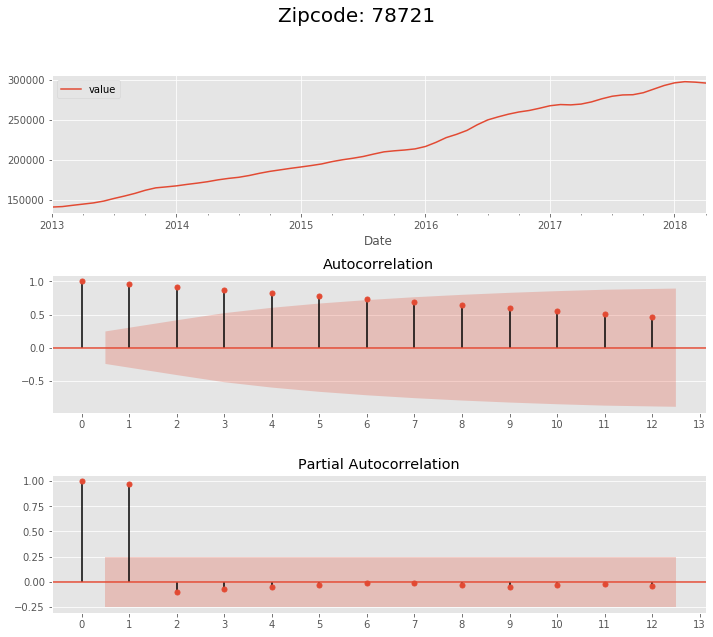

In [15]:
zip_78721 = zips_grouped.loc[78721]
plot_acf_pacf(zip_78721, 78721)
plt.show()

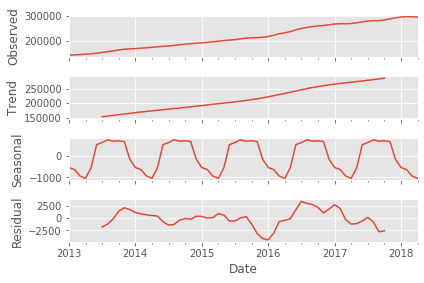

In [17]:
decompose_result = seasonal_decompose(zip_78721, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

In [18]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [19]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(zip_78721,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =1732.4393222305996
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1385.8860191136334
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1207.291537828405
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =916.8158858103315
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =863.1687539700204
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =1354.8172183755216
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1099.258678273307
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1087.2241670384356
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =884.2759659703605
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1208.5523097291266
ARIMA (0, 0, 0) x (1, 2, 0, 12)12 : AIC Calculated =618.542006785905
ARIMA (0, 0, 0) x (1, 2, 1, 12)12 : AIC Calculated =592.2325355504713
ARIMA (0, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =821.4144630417628
ARIMA (0, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =820.0154862702011
ARIMA (0, 0, 0) 

ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =653.827262460648
ARIMA (0, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =477.29458511617645
ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =925.0679922088486
ARIMA (0, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =653.4498903430969
ARIMA (0, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =653.8960776257742
ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =462.9696435606172
ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =477.64690881468647
ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =256.5701959924347
ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =2.0178803063094304e+17
ARIMA (0, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =1005.0091874311437
ARIMA (0, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated =804.9202176563573
ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =839.8156542519212
ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =634.5325064981434
ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =671.7360216794523
ARIMA (0, 2, 

ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =646.6042188740594
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =686.0640936581538
ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =1012.2693938245397
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =835.5566969097239
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =821.5407458717705
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =663.6241334404428
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =652.4448452505242
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =478.85890288400896
ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =1058.2880009407027
ARIMA (1, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =656.665301179498
ARIMA (1, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =661.244569979862
ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =468.39781047781537
ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =461.3857324596262
ARIMA (1, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =258.56418343843643
ARIMA (1, 1, 1) x

ARIMA (2, 0, 1) x (2, 0, 0, 12)12 : AIC Calculated =646.1119641376373
ARIMA (2, 0, 1) x (2, 0, 1, 12)12 : AIC Calculated =646.59611003616
ARIMA (2, 0, 1) x (2, 1, 0, 12)12 : AIC Calculated =455.6102439584732
ARIMA (2, 0, 1) x (2, 1, 1, 12)12 : AIC Calculated =485.79539564491876
ARIMA (2, 0, 1) x (2, 2, 0, 12)12 : AIC Calculated =251.15182412677456
ARIMA (2, 0, 1) x (2, 2, 1, 12)12 : AIC Calculated =257.0012917966713
ARIMA (2, 0, 2) x (0, 0, 0, 12)12 : AIC Calculated =992.9305190809181
ARIMA (2, 0, 2) x (0, 0, 1, 12)12 : AIC Calculated =806.03218627545
ARIMA (2, 0, 2) x (0, 1, 0, 12)12 : AIC Calculated =858.1851338782886
ARIMA (2, 0, 2) x (0, 1, 1, 12)12 : AIC Calculated =777.5621256074367
ARIMA (2, 0, 2) x (0, 2, 0, 12)12 : AIC Calculated =687.6650363880904
ARIMA (2, 0, 2) x (0, 2, 1, 12)12 : AIC Calculated =1132.0846944446264
ARIMA (2, 0, 2) x (1, 0, 0, 12)12 : AIC Calculated =821.3837094502437
ARIMA (2, 0, 2) x (1, 0, 1, 12)12 : AIC Calculated =807.4474952736076
ARIMA (2, 0, 2) x (1,

ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =982.8368549763977
ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =799.7574579415925
ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =783.7394303904123
ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =627.2766354321715
ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =608.9818667441837
ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =436.58539808966185
ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =842.4109652454187
ARIMA (2, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =608.5898780457484
ARIMA (2, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =610.7282883198229
ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =418.8800537209878
ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =419.51987633584383
ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =224.12713259769083
ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =225.51061361717663


In [20]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (2, 2, 0)
pdqs    (2, 2, 0, 12)
aic           218.966
Name: 448, dtype: object

In [21]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zip_78721, 
                                        order=(2, 2, 0), 
                                        seasonal_order=(2, 2, 0, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3591      0.447      0.804      0.422      -0.517       1.235
ar.L2         -0.3258      0.329     -0.992      0.321      -0.970       0.318
ar.S.L12      -0.9117      0.471     -1.934      0.053      -1.836       0.012
ar.S.L24      -0.2447      0.979     -0.250      0.803      -2.163       1.673
sigma2      2.139e+06   7.48e+05      2.862      0.004    6.74e+05     3.6e+06


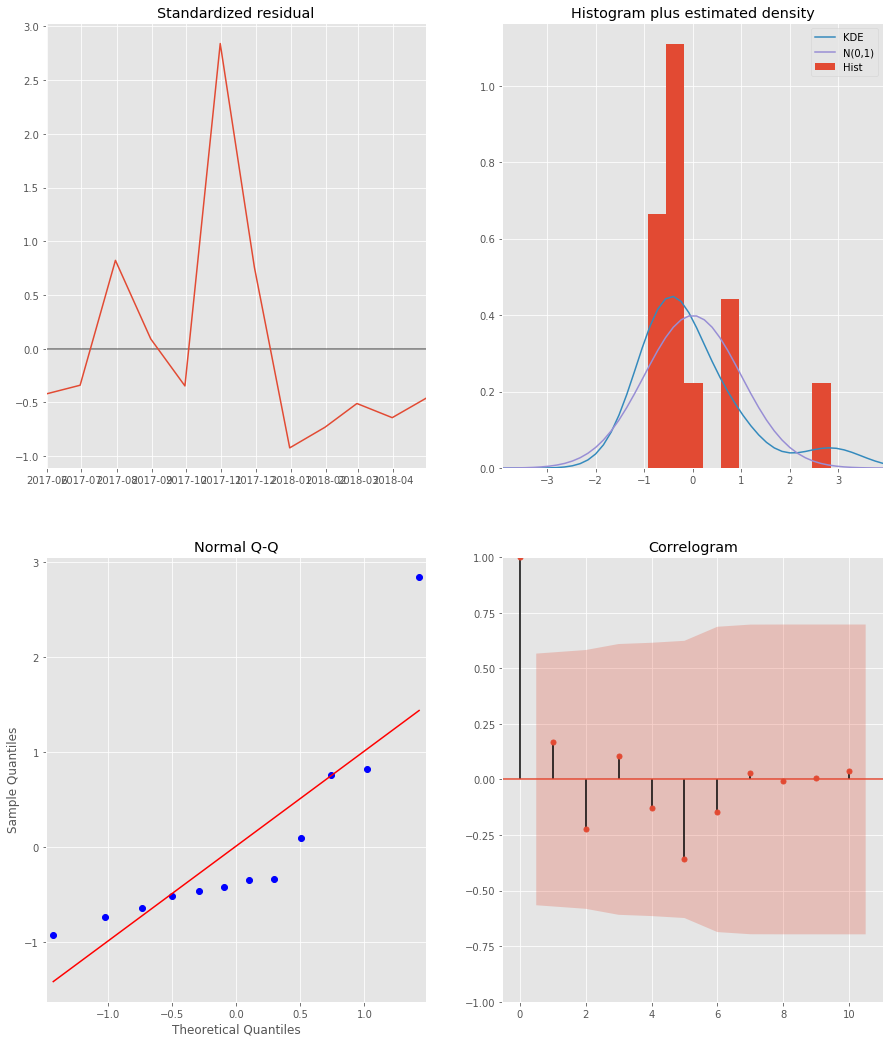

In [22]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [24]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_conf = pred.conf_int()

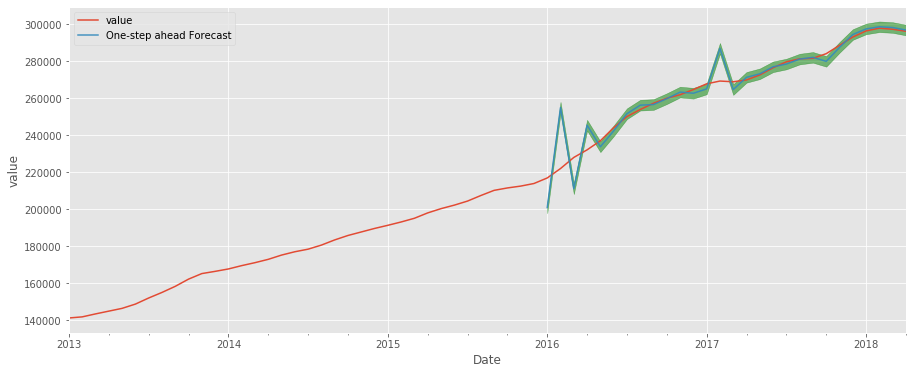

In [25]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = zip_78721['2013':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()

plt.show()

In [26]:
# Get the real and predicted values
zip_78721_forecasted = pred.predicted_mean
zip_78721_truth = zip_78721['value']['2016-01-31':]

# Compute the mean square error
mse = ((zip_78721_forecasted - zip_78721_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 78606697.26


In [27]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

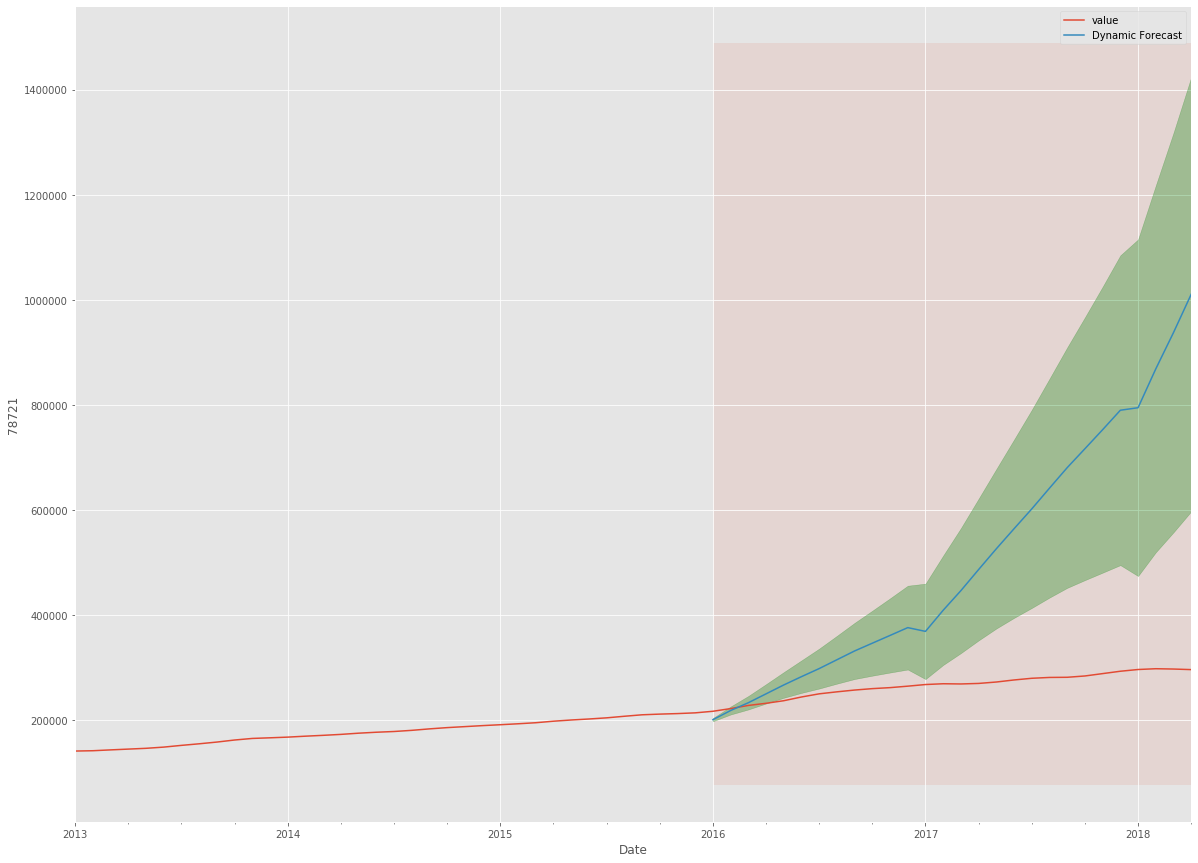

In [28]:
# Plot the dynamic forecast with confidence intervals.

ax = zip_78721['2013':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), zip_78721_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('78721')

plt.legend()
plt.show()

In [29]:
# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()


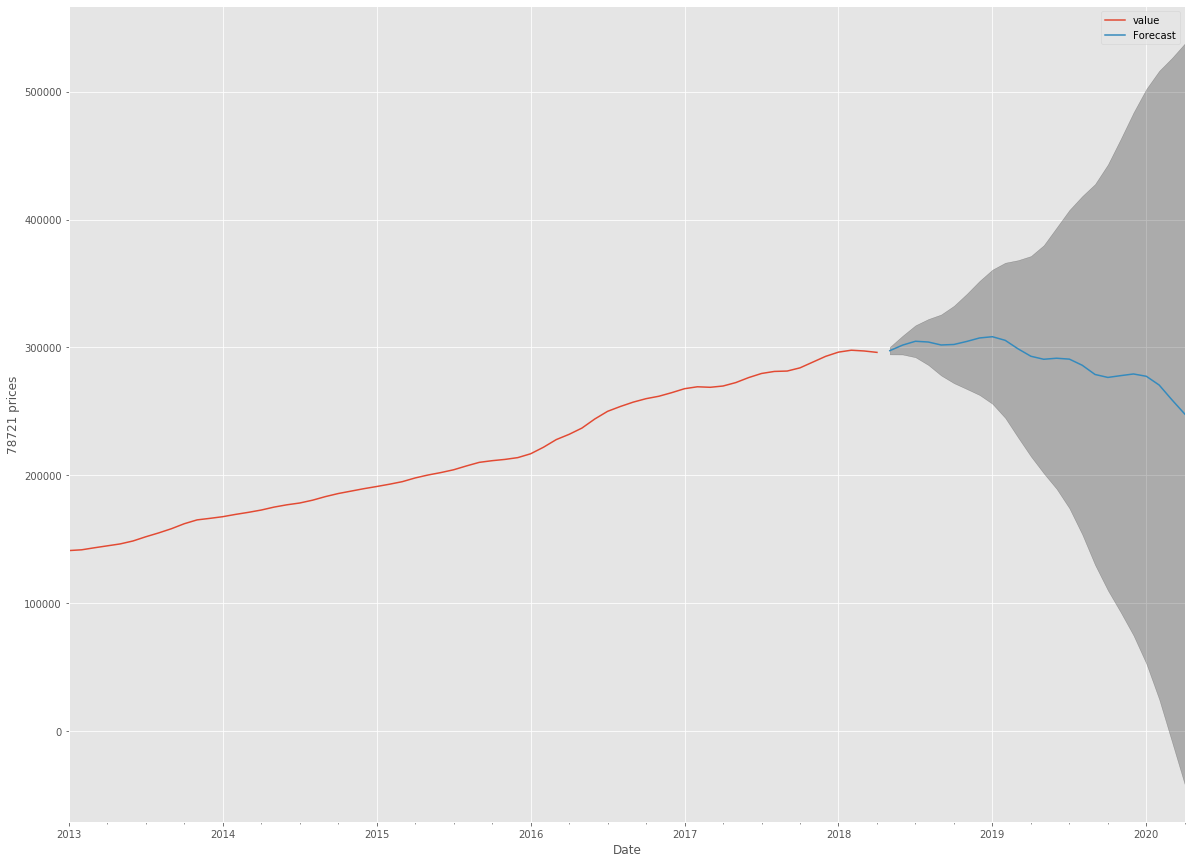

In [30]:
# Plot future predictions with confidence intervals
ax = zip_78721.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('78721 prices')

plt.legend()
plt.show()

In [31]:
pred_conf['mean'] = prediction.predicted_mean

pred_conf.head()

,lower value,upper value,mean
2018-05-31,294568.112962,300301.534875,297434.823919
2018-06-30,294452.671120,309143.297690,301797.984405
2018-07-31,292309.741064,317277.826661,304793.783862
2018-08-31,286268.643050,322154.612861,304211.627955
2018-09-30,278066.879413,325714.239507,301890.559460


In [32]:
roi_2 = (pred_conf.iloc[23][2] - pred_conf.iloc[0][2])/pred_conf.iloc[0][2] * 100
roi_2

-16.67624527141904

In [33]:
pred_roi_df = pd.DataFrame(columns=['zipcode', 'roi_2'])
pred_roi_df.loc[len(pred_roi_df.index)] = [78702, roi_2] 
pred_roi_df

,zipcode,roi_2
0,78702.0,-16.676245


In [34]:
zips_grouped.to_pickle("zips_grouped.pkl")
pred_roi_df.to_pickle("pred_roi_df.pkl")